# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=intro_to_nn_tf2-colab&hl=en

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

## Normalize values

When building a model with multiple features, the values of each feature should cover roughly the same range.  The following code cell normalizes datasets by converting each raw value to its Z-score. (For more information about Z-scores, see the Classification exercise.)

In [3]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = orign_train_df.mean()
train_df_std = orign_train_df.std()
train_df_norm = (orign_train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


In [4]:
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
# my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_columns

[NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [5]:
resolution_in_Zs = 0.3  

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
# latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))

print("latitude_boundaries: ", latitude_boundaries)
# latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
#                                                latitude_boundaries)
feature_columns.append("latitude")

# Create a bucket feature column for longitude.
# longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
print("longitude_boundaries: ", longitude_boundaries)
# longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
#                                                 longitude_boundaries)
feature_columns.append("longitude")

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
# buckets_feature_layer = layers.DenseFeatures(feature_columns)

feature_columns = ["latitude", "longitude", "median_income", "population"]
feature_columns

latitude_boundaries:  [-1.0, -0.7, -0.3999999999999999, -0.09999999999999987, 0.20000000000000018, 0.5000000000000002, 0.8000000000000003, 1.1000000000000005, 1.4000000000000004, 1.7000000000000002]
longitude_boundaries:  [-2.0, -1.7, -1.4, -1.0999999999999999, -0.7999999999999998, -0.4999999999999998, -0.19999999999999973, 0.10000000000000053, 0.40000000000000036, 0.7000000000000002, 1.0000000000000004, 1.3000000000000007, 1.6000000000000005, 1.9000000000000004]


['latitude', 'longitude', 'median_income', 'population']

In [6]:
def latitude_app(val, l):
    
    if val < l[0]: return 0
    
    for idx, item in enumerate(l[1:]):
        if val < item: return idx
    
    if val > l[-1]: return len(l) + 1
    

def longitude_app(val, l):
    if val < l[0]: return 0
    
    for idx, item in enumerate(l[1:]):
        if val < item: return idx
    
    if val > l[-1]: return len(l) + 1  

train_df_norm['latitude'] = train_df_norm.apply(lambda r: latitude_app(r['latitude'], latitude_boundaries), axis=1)
train_df_norm['longitude'] = train_df_norm.apply(lambda r: longitude_app(r['longitude'], longitude_boundaries), axis=1) 

test_df_norm['latitude'] = test_df_norm.apply(lambda r: latitude_app(r['latitude'], latitude_boundaries), axis=1)
test_df_norm['longitude'] = test_df_norm.apply(lambda r: longitude_app(r['longitude'], longitude_boundaries), axis=1) 

In [7]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
12501,3,4,1.3,-0.4,-0.3,0.1,-0.2,-0.5,-0.7
11215,4,8,-1.4,-0.3,-0.6,-0.6,-0.6,-0.0,-0.2
5013,9,0,0.6,-0.4,-0.5,-0.5,-0.4,0.4,0.1
7614,8,0,-0.5,0.7,1.7,0.3,1.7,-0.4,1.2
12792,2,5,-0.9,0.6,0.5,1.1,0.6,0.6,0.1


In [8]:
len(train_df_norm.columns)

9

## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the feature layer you just created. 


In [9]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(len(feature_columns), 1)                    
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 15
batch_size = 1000
label_name = "median_house_value"


# train_df, valid_df = train_test_split(train_df_norm, test_size=0.2)

from sklearn.model_selection import train_test_split

tfm = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

class MyDataset(Dataset):
 
    def __init__(self, df, tfm):
       
        self.transform = tfm
        x=df[feature_columns].values
        y=df[[label_name]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)    
           

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(train_df_norm, tfm)
# valid_ds = MyDataset(valid_df, tfm)
test_ds = MyDataset(test_df_norm, tfm)


train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)

# valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [11]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")


[ Epoch | 001/015 ]           train_loss = 0.72899 mean_squared_error = 0.72899



[ Epoch | 002/015 ]           train_loss = 0.53634 mean_squared_error = 0.53634



[ Epoch | 003/015 ]           train_loss = 0.51682 mean_squared_error = 0.51682



[ Epoch | 004/015 ]           train_loss = 0.50613 mean_squared_error = 0.50613



[ Epoch | 005/015 ]           train_loss = 0.49705 mean_squared_error = 0.49705



[ Epoch | 006/015 ]           train_loss = 0.48894 mean_squared_error = 0.48894



[ Epoch | 007/015 ]           train_loss = 0.48169 mean_squared_error = 0.48169



[ Epoch | 008/015 ]           train_loss = 0.47519 mean_squared_error = 0.47519



[ Epoch | 009/015 ]           train_loss = 0.46938 mean_squared_error = 0.46938



[ Epoch | 010/015 ]           train_loss = 0.46418 mean_squared_error = 0.46418



[ Epoch | 011/015 ]           train_loss = 0.45952 mean_squared_error = 0.45952



[ Epoch | 012/015 ]           train_loss = 0.45535 mean_squared_error = 0.45535



[ Epoch | 013/015 ]           train_loss = 0.45163 mean_squared_error = 0.45163



[ Epoch | 014/015 ]           train_loss = 0.44830 mean_squared_error = 0.44830



[ Epoch | 015/015 ]           train_loss = 0.44533 mean_squared_error = 0.44533
Defined the build_model and train_model functions.


In [12]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 0.46419 mean_squared_error = 0.46419


## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [13]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(len(feature_columns), 20) ,                   
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
)

## Define a training function

The `train_model` function trains the model from the input features and labels. The [tf.keras.Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 20
batch_size = 1000


[ Epoch | 001/020 ]           train_loss = 3.80684 mean_squared_error = 3.80684



[ Epoch | 002/020 ]           train_loss = 0.51735 mean_squared_error = 0.51735



[ Epoch | 003/020 ]           train_loss = 0.51010 mean_squared_error = 0.51010



[ Epoch | 004/020 ]           train_loss = 0.50457 mean_squared_error = 0.50457



[ Epoch | 005/020 ]           train_loss = 0.49868 mean_squared_error = 0.49868



[ Epoch | 006/020 ]           train_loss = 0.49243 mean_squared_error = 0.49243



[ Epoch | 007/020 ]           train_loss = 0.48583 mean_squared_error = 0.48583



[ Epoch | 008/020 ]           train_loss = 0.47901 mean_squared_error = 0.47901



[ Epoch | 009/020 ]           train_loss = 0.47264 mean_squared_error = 0.47264



[ Epoch | 010/020 ]           train_loss = 0.46907 mean_squared_error = 0.46907



[ Epoch | 011/020 ]           train_loss = 0.46705 mean_squared_error = 0.46705



[ Epoch | 012/020 ]           train_loss = 0.46426 mean_squared_error = 0.46426



[ Epoch | 013/020 ]           train_loss = 0.46293 mean_squared_error = 0.46293



[ Epoch | 014/020 ]           train_loss = 0.46031 mean_squared_error = 0.46031



[ Epoch | 015/020 ]           train_loss = 0.45799 mean_squared_error = 0.45799



[ Epoch | 016/020 ]           train_loss = 0.45532 mean_squared_error = 0.45532



[ Epoch | 017/020 ]           train_loss = 0.45323 mean_squared_error = 0.45323



[ Epoch | 018/020 ]           train_loss = 0.45114 mean_squared_error = 0.45114



[ Epoch | 019/020 ]           train_loss = 0.44945 mean_squared_error = 0.44945



[ Epoch | 020/020 ]           train_loss = 0.44784 mean_squared_error = 0.44784
Defined the build_model and train_model functions.


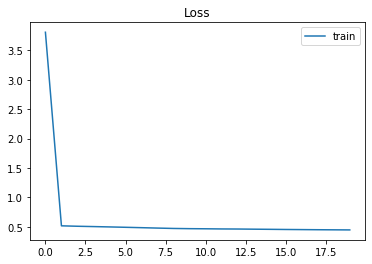

In [15]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")



import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [16]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 0.45607 mean_squared_error = 0.45607


## Task 3: Regularize the deep neural network (if you have enough time)

Notice that the model's loss against the test set is *much higher* than the loss against the training set.  In other words, the deep neural network is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set.  To reduce overfitting, regularize the model.  The course has suggested several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.01. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```



In [17]:
# https://pyquestions.com/adding-l1-l2-regularization-in-pytorch
# https://github.com/szymonmaszke/torchlayers/blob/master/torchlayers/regularization.py

class L1(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L1 regularization formula
        return self.weight_decay * torch.sign(parameter.data)

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)
    
class L2(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L2 regularization formula
        return self.weight_decay * parameter.data

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)    

### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training. 


In [18]:
learning_rate = 0.007
n_epochs = 140
batch_size = 1000

In [19]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    L2(nn.Linear(len(feature_columns), 20), weight_decay=0.01) ,   
                    nn.Dropout(0.25),
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): L2(
      (module): Linear(in_features=4, out_features=20, bias=True)
    )
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Linear(in_features=12, out_features=1, bias=True)
  )
)


[ Epoch | 001/140 ]           train_loss = 1.38329 mean_squared_error = 1.38329



[ Epoch | 002/140 ]           train_loss = 0.82657 mean_squared_error = 0.82657



[ Epoch | 003/140 ]           train_loss = 0.65015 mean_squared_error = 0.65015



[ Epoch | 004/140 ]           train_loss = 0.57588 mean_squared_error = 0.57588



[ Epoch | 005/140 ]           train_loss = 0.54896 mean_squared_error = 0.54896



[ Epoch | 006/140 ]           train_loss = 0.52984 mean_squared_error = 0.52984



[ Epoch | 007/140 ]           train_loss = 0.50746 mean_squared_error = 0.50746



[ Epoch | 008/140 ]           train_loss = 0.49416 mean_squared_error = 0.49416



[ Epoch | 009/140 ]           train_loss = 0.47809 mean_squared_error = 0.47809



[ Epoch | 010/140 ]           train_loss = 0.47138 mean_squared_error = 0.47138



[ Epoch | 011/140 ]           train_loss = 0.46094 mean_squared_error = 0.46094



[ Epoch | 012/140 ]           train_loss = 0.45330 mean_squared_error = 0.45330



[ Epoch | 013/140 ]           train_loss = 0.45235 mean_squared_error = 0.45235



[ Epoch | 014/140 ]           train_loss = 0.45007 mean_squared_error = 0.45007



[ Epoch | 015/140 ]           train_loss = 0.44972 mean_squared_error = 0.44972



[ Epoch | 016/140 ]           train_loss = 0.44908 mean_squared_error = 0.44908



[ Epoch | 017/140 ]           train_loss = 0.44642 mean_squared_error = 0.44642



[ Epoch | 018/140 ]           train_loss = 0.44319 mean_squared_error = 0.44319



[ Epoch | 019/140 ]           train_loss = 0.44115 mean_squared_error = 0.44115



[ Epoch | 020/140 ]           train_loss = 0.44335 mean_squared_error = 0.44335



[ Epoch | 021/140 ]           train_loss = 0.44436 mean_squared_error = 0.44436



[ Epoch | 022/140 ]           train_loss = 0.44371 mean_squared_error = 0.44371



[ Epoch | 023/140 ]           train_loss = 0.44172 mean_squared_error = 0.44172



[ Epoch | 024/140 ]           train_loss = 0.44304 mean_squared_error = 0.44304



[ Epoch | 025/140 ]           train_loss = 0.44213 mean_squared_error = 0.44213



[ Epoch | 026/140 ]           train_loss = 0.44116 mean_squared_error = 0.44116



[ Epoch | 027/140 ]           train_loss = 0.44306 mean_squared_error = 0.44306



[ Epoch | 028/140 ]           train_loss = 0.44093 mean_squared_error = 0.44093



[ Epoch | 029/140 ]           train_loss = 0.43945 mean_squared_error = 0.43945



[ Epoch | 030/140 ]           train_loss = 0.44034 mean_squared_error = 0.44034



[ Epoch | 031/140 ]           train_loss = 0.43896 mean_squared_error = 0.43896



[ Epoch | 032/140 ]           train_loss = 0.44420 mean_squared_error = 0.44420



[ Epoch | 033/140 ]           train_loss = 0.43996 mean_squared_error = 0.43996



[ Epoch | 034/140 ]           train_loss = 0.44076 mean_squared_error = 0.44076



[ Epoch | 035/140 ]           train_loss = 0.43794 mean_squared_error = 0.43794



[ Epoch | 036/140 ]           train_loss = 0.43930 mean_squared_error = 0.43930



[ Epoch | 037/140 ]           train_loss = 0.43615 mean_squared_error = 0.43615



[ Epoch | 038/140 ]           train_loss = 0.43913 mean_squared_error = 0.43913



[ Epoch | 039/140 ]           train_loss = 0.43960 mean_squared_error = 0.43960



[ Epoch | 040/140 ]           train_loss = 0.43603 mean_squared_error = 0.43603



[ Epoch | 041/140 ]           train_loss = 0.43698 mean_squared_error = 0.43698



[ Epoch | 042/140 ]           train_loss = 0.43877 mean_squared_error = 0.43877



[ Epoch | 043/140 ]           train_loss = 0.44127 mean_squared_error = 0.44127



[ Epoch | 044/140 ]           train_loss = 0.43733 mean_squared_error = 0.43733



[ Epoch | 045/140 ]           train_loss = 0.43649 mean_squared_error = 0.43649



[ Epoch | 046/140 ]           train_loss = 0.43707 mean_squared_error = 0.43707



[ Epoch | 047/140 ]           train_loss = 0.43730 mean_squared_error = 0.43730



[ Epoch | 048/140 ]           train_loss = 0.43857 mean_squared_error = 0.43857



[ Epoch | 049/140 ]           train_loss = 0.43760 mean_squared_error = 0.43760



[ Epoch | 050/140 ]           train_loss = 0.43975 mean_squared_error = 0.43975



[ Epoch | 051/140 ]           train_loss = 0.43686 mean_squared_error = 0.43686



[ Epoch | 052/140 ]           train_loss = 0.43941 mean_squared_error = 0.43941



[ Epoch | 053/140 ]           train_loss = 0.43551 mean_squared_error = 0.43551



[ Epoch | 054/140 ]           train_loss = 0.43507 mean_squared_error = 0.43507



[ Epoch | 055/140 ]           train_loss = 0.43637 mean_squared_error = 0.43637



[ Epoch | 056/140 ]           train_loss = 0.43558 mean_squared_error = 0.43558



[ Epoch | 057/140 ]           train_loss = 0.43740 mean_squared_error = 0.43740



[ Epoch | 058/140 ]           train_loss = 0.43615 mean_squared_error = 0.43615



[ Epoch | 059/140 ]           train_loss = 0.43884 mean_squared_error = 0.43884



[ Epoch | 060/140 ]           train_loss = 0.43796 mean_squared_error = 0.43796



[ Epoch | 061/140 ]           train_loss = 0.43603 mean_squared_error = 0.43603



[ Epoch | 062/140 ]           train_loss = 0.43576 mean_squared_error = 0.43576



[ Epoch | 063/140 ]           train_loss = 0.43587 mean_squared_error = 0.43587



[ Epoch | 064/140 ]           train_loss = 0.43587 mean_squared_error = 0.43587



[ Epoch | 065/140 ]           train_loss = 0.43610 mean_squared_error = 0.43610



[ Epoch | 066/140 ]           train_loss = 0.43492 mean_squared_error = 0.43492



[ Epoch | 067/140 ]           train_loss = 0.43791 mean_squared_error = 0.43791



[ Epoch | 068/140 ]           train_loss = 0.43741 mean_squared_error = 0.43741



[ Epoch | 069/140 ]           train_loss = 0.43418 mean_squared_error = 0.43418



[ Epoch | 070/140 ]           train_loss = 0.43553 mean_squared_error = 0.43553



[ Epoch | 071/140 ]           train_loss = 0.43704 mean_squared_error = 0.43704



[ Epoch | 072/140 ]           train_loss = 0.43369 mean_squared_error = 0.43369



[ Epoch | 073/140 ]           train_loss = 0.43458 mean_squared_error = 0.43458



[ Epoch | 074/140 ]           train_loss = 0.43734 mean_squared_error = 0.43734



[ Epoch | 075/140 ]           train_loss = 0.43597 mean_squared_error = 0.43597



[ Epoch | 076/140 ]           train_loss = 0.43654 mean_squared_error = 0.43654



[ Epoch | 077/140 ]           train_loss = 0.43521 mean_squared_error = 0.43521



[ Epoch | 078/140 ]           train_loss = 0.43610 mean_squared_error = 0.43610



[ Epoch | 079/140 ]           train_loss = 0.43683 mean_squared_error = 0.43683



[ Epoch | 080/140 ]           train_loss = 0.43653 mean_squared_error = 0.43653



[ Epoch | 081/140 ]           train_loss = 0.43711 mean_squared_error = 0.43711



[ Epoch | 082/140 ]           train_loss = 0.43832 mean_squared_error = 0.43832



[ Epoch | 083/140 ]           train_loss = 0.43543 mean_squared_error = 0.43543



[ Epoch | 084/140 ]           train_loss = 0.43819 mean_squared_error = 0.43819



[ Epoch | 085/140 ]           train_loss = 0.43546 mean_squared_error = 0.43546



[ Epoch | 086/140 ]           train_loss = 0.43840 mean_squared_error = 0.43840



[ Epoch | 087/140 ]           train_loss = 0.43604 mean_squared_error = 0.43604



[ Epoch | 088/140 ]           train_loss = 0.43481 mean_squared_error = 0.43481



[ Epoch | 089/140 ]           train_loss = 0.43617 mean_squared_error = 0.43617



[ Epoch | 090/140 ]           train_loss = 0.43384 mean_squared_error = 0.43384



[ Epoch | 091/140 ]           train_loss = 0.43567 mean_squared_error = 0.43567



[ Epoch | 092/140 ]           train_loss = 0.43559 mean_squared_error = 0.43559



[ Epoch | 093/140 ]           train_loss = 0.43392 mean_squared_error = 0.43392



[ Epoch | 094/140 ]           train_loss = 0.43537 mean_squared_error = 0.43537



[ Epoch | 095/140 ]           train_loss = 0.43546 mean_squared_error = 0.43546



[ Epoch | 096/140 ]           train_loss = 0.43647 mean_squared_error = 0.43647



[ Epoch | 097/140 ]           train_loss = 0.43563 mean_squared_error = 0.43563



[ Epoch | 098/140 ]           train_loss = 0.43517 mean_squared_error = 0.43517



[ Epoch | 099/140 ]           train_loss = 0.43520 mean_squared_error = 0.43520



[ Epoch | 100/140 ]           train_loss = 0.43431 mean_squared_error = 0.43431



[ Epoch | 101/140 ]           train_loss = 0.43243 mean_squared_error = 0.43243



[ Epoch | 102/140 ]           train_loss = 0.43556 mean_squared_error = 0.43556



[ Epoch | 103/140 ]           train_loss = 0.43392 mean_squared_error = 0.43392



[ Epoch | 104/140 ]           train_loss = 0.43331 mean_squared_error = 0.43331



[ Epoch | 105/140 ]           train_loss = 0.43274 mean_squared_error = 0.43274



[ Epoch | 106/140 ]           train_loss = 0.43374 mean_squared_error = 0.43374



[ Epoch | 107/140 ]           train_loss = 0.43164 mean_squared_error = 0.43164



[ Epoch | 108/140 ]           train_loss = 0.43522 mean_squared_error = 0.43522



[ Epoch | 109/140 ]           train_loss = 0.43347 mean_squared_error = 0.43347



[ Epoch | 110/140 ]           train_loss = 0.43165 mean_squared_error = 0.43165



[ Epoch | 111/140 ]           train_loss = 0.43330 mean_squared_error = 0.43330



[ Epoch | 112/140 ]           train_loss = 0.43223 mean_squared_error = 0.43223



[ Epoch | 113/140 ]           train_loss = 0.43263 mean_squared_error = 0.43263



[ Epoch | 114/140 ]           train_loss = 0.43421 mean_squared_error = 0.43421



[ Epoch | 115/140 ]           train_loss = 0.43329 mean_squared_error = 0.43329



[ Epoch | 116/140 ]           train_loss = 0.43359 mean_squared_error = 0.43359



[ Epoch | 117/140 ]           train_loss = 0.43495 mean_squared_error = 0.43495



[ Epoch | 118/140 ]           train_loss = 0.43378 mean_squared_error = 0.43378



[ Epoch | 119/140 ]           train_loss = 0.43417 mean_squared_error = 0.43417



[ Epoch | 120/140 ]           train_loss = 0.43343 mean_squared_error = 0.43343



[ Epoch | 121/140 ]           train_loss = 0.43234 mean_squared_error = 0.43234



[ Epoch | 122/140 ]           train_loss = 0.43246 mean_squared_error = 0.43246



[ Epoch | 123/140 ]           train_loss = 0.43180 mean_squared_error = 0.43180



[ Epoch | 124/140 ]           train_loss = 0.43372 mean_squared_error = 0.43372



[ Epoch | 125/140 ]           train_loss = 0.43192 mean_squared_error = 0.43192



[ Epoch | 126/140 ]           train_loss = 0.43247 mean_squared_error = 0.43247



[ Epoch | 127/140 ]           train_loss = 0.43163 mean_squared_error = 0.43163



[ Epoch | 128/140 ]           train_loss = 0.43116 mean_squared_error = 0.43116



[ Epoch | 129/140 ]           train_loss = 0.43251 mean_squared_error = 0.43251



[ Epoch | 130/140 ]           train_loss = 0.43170 mean_squared_error = 0.43170



[ Epoch | 131/140 ]           train_loss = 0.43396 mean_squared_error = 0.43396



[ Epoch | 132/140 ]           train_loss = 0.43128 mean_squared_error = 0.43128



[ Epoch | 133/140 ]           train_loss = 0.43269 mean_squared_error = 0.43269



[ Epoch | 134/140 ]           train_loss = 0.43285 mean_squared_error = 0.43285



[ Epoch | 135/140 ]           train_loss = 0.43223 mean_squared_error = 0.43223



[ Epoch | 136/140 ]           train_loss = 0.43200 mean_squared_error = 0.43200



[ Epoch | 137/140 ]           train_loss = 0.43402 mean_squared_error = 0.43402



[ Epoch | 138/140 ]           train_loss = 0.43351 mean_squared_error = 0.43351



[ Epoch | 139/140 ]           train_loss = 0.43179 mean_squared_error = 0.43179



[ Epoch | 140/140 ]           train_loss = 0.43251 mean_squared_error = 0.43251
Defined the build_model and train_model functions.


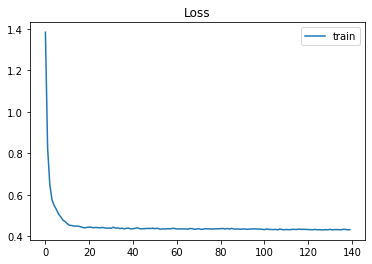

In [20]:
model = Sequential()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0, amsgrad=False)

loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")

import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [21]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 0.43985 mean_squared_error = 0.43985
